Pour ce nouveau TP, nous allons manipuler les notions vues lors deux précédents TPs afin de mettre en place les mécanismes de *Retrieval Augmented Generation* (RAG). Ce mécanisme permet à un LLM de générer des réponses sourcées et d'améliorer ainsi la fiabilité du texte généré.

<center> <img src="https://drive.google.com/thumbnail?id=1GwUiaFmVrKzfbFZywX8jd73zXSeZDhyy&sz=w1000" style="width:800;height:400px;"></center>
<caption><center><b> Illustration d'un pipeline de RAG </b></center></caption>


L'idée, représentée dans le diagramme ci-dessus, nécessite plusieurs étapes successives :

-   On commence par indexer une base de connaissances (partie supérieure du graphe). Pour cela, on va découper cette base en unités de taille moyenne (typiquement, un ou plusieurs paragraphes) et utiliser un modèle de langage (de type BERT) pour associer à chaque unité de connaissance un descripteur, dont on espère qu'il porte une information sémantique représentative du contenu textuel. Dans l'espace des descripteurs, deux paragraphes de sens voisin devraient se retrouver à une distance assez faible l'un de l'autre.

-   Lorsqu'un utilisateur tape ensuite un prompt pour un modèle génératif, on génère le descripteur de ce prompt et on le compare aux descripteurs de la base de connaissances, afin d'identifier les connaissances pertinentes pour répondre à la question posée.

-   On ajoute ainsi le paragraphe correspondant en contexte du prompt afin d'aider le modèle de langage (de type GPT) à générer une réponse pertinente.

# Modèle de Langage "instruction-tuned"

Les modèles de langage génératifs que nous avons manipulé au TP précédent sont très performants pour générer du texte mais nécessitent quelques modifications pour être utilisés au sein, par exemple, d'un client de chat (type ChatGPT). Les modèles "instruction-tuned" sont ainsi des modèles de langage génératifs, de type décodeur (i.e. de la famille de GPT) mais qui ont été *fine-tuned* avec un ensemble d'apprentissage spécifique leur permettant d'intégrer des informations supplémentaires lors de la génération.

Ainsi, par exemple, il est possible de tagger le texte d'un prompt comme étant écrit soit par un utilisateur, soit par le modèle : ce mécanisme rend possible des "conversations" entre un utilisateur et le modèle, car il permet d'inclure dans le prompt courant les échanges précédents.

```
<start_of_turn>user
knock knock<end_of_turn>
<start_of_turn>model
who is there<end_of_turn>
<start_of_turn>user
Gemma<end_of_turn>
<start_of_turn>model
Gemma who?<end_of_turn>
```
(exemple extrait de [la documentation de Gemma](https://ai.google.dev/gemma/docs/core/prompt-structure))

Dans ce TP, nous allons utiliser le modèle de DataBricks dolly-v2-3B (pour *instruction-tuned*), qui est un modèle gratuit *instruction-tuned* relativement compact.

In [1]:
import torch
from transformers import pipeline

generate_text = pipeline(model="databricks/dolly-v2-3b", torch_dtype=torch.bfloat16, trust_remote_code=True, device_map="auto")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

instruct_pipeline.py:   0%|          | 0.00/9.16k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/databricks/dolly-v2-3b:
- instruct_pipeline.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/5.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.68G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Device set to use cuda:0


Pour poser une question au modèle, vous pouvez utiliser les commandes suivantes :

```
res = generate_text("Ask your question in english")
print(res[0]["generated_text"])
```

In [89]:
prompt = """### Instruction:
When will Nintendo release the Switch 2 ?

### Context:
Nintendo revealed the Switch 2 on January 16, 2025, followed by its full specifications and release date on April 2. It is scheduled for release in most territories on June 5, 2025.

### Response:
"""

res = generate_text(prompt)
print(res[0]["generated_text"])

### Response:
Nintendo released the Switch in 2023 and started introducing new features every few years to keep the market continuously growing. It is expected that the Switch 2 will have an improved GPU with higher processing power and more storage space in order to handle the growing online market. It is also being speculated that Nintendo will include dedicated second screen functionality for users to play individual games within the library on the Switch. It is expected that the Switch 2 will be available at a lower price point than its current console, the Nintendo Switch, due to the lower manufacturing cost of its components.


**Travail à faire** : faites des tests et essayez de trouver des questions qui mettent en erreur le modèle. N'hésitez pas à relancer la prédiction plusieurs fois pour évaluer la stabilité de la réponse du modèle.

Une fois que vous avez identifié une ou plusieurs questions pour lesquelles le modèle se trompe, cherchez (par exemple, sur Wikipedia) un paragraphe qui contient quelque part la réponse à ce ou ces questions. Il est possible de fournir un contexte à Dolly en structurant le prompt en différentes parties : instructions / Contexte / Réponse. Voici comment l'on peut s'y prendre :

```
prompt = """### Instruction:
Ask your question in english here

### Context:
Copy/Paste here your paragraph of context

### Response:
"""

res = generate_text(prompt)
print(res[0]["generated_text"])
```

**Travail à faire** : Vérifiez que votre modèle utilise bien le contexte pour répondre maintenant correctement à votre question.

## Un exemple illustratif (mais c'est mieux si vous le faites vous-même)

Demandons au modèle qui était le roi de France en 1700 ? Le modèle prédit correctement Louis XIV. En revanche, essayez un peu de modifier les dates. Louis XIV est mort en 1715, mais si vous demandez au modèle qui était le roi en 1716, il prédit également Louis XIV (bien que, de temps en temps, il prédise également Louis XV).

In [8]:
res = generate_text("Who was the french king in 1716?")
print(res[0]["generated_text"])

Louis XV of France


Nous allons maintenant donner du contexte au modèle pour faire sa prédiction. Copions ainsi le paragraphe suivant, extrait de [Wikipedia](https://en.wikipedia.org/wiki/Louis_XV) :    

```
Louis XV (15 February 1710 – 10 May 1774), known as Louis the Beloved (French:
le Bien-Aimé),[1] was King of France from 1 September 1715 until his death in
1774. He succeeded his great-grandfather Louis XIV at the age of five. Until
he reached maturity (then defined as his 13th birthday) in 1723, the kingdom
was ruled by his grand-uncle Philippe II, Duke of Orléans, as Regent of
France. Cardinal Fleury was chief minister from 1726 until his death in
1743, at which time the king took sole control of the kingdom.
```


Pour fournir un contexte à Dolly, il faut structurer le prompt en différentes parties : instructions / Contexte / Réponse. Voici comment l'on peut s'y prendre :


In [32]:
prompt = """### Instruction:
Who was the french king in 1716?

### Context:
Louis XV (15 February 1710 – 10 May 1774), known as Louis the Beloved (French: le Bien-Aimé),[1] was King of France from 1 September 1715 until his death in 1774. He succeeded his great-grandfather Louis XIV at the age of five. Until he reached maturity (then defined as his 13th birthday) in 1723, the kingdom was ruled by his grand-uncle Philippe II, Duke of Orléans, as Regent of France. Cardinal Fleury was chief minister from 1726 until his death in 1743, at which time the king took sole control of the kingdom.### Response:
"""

res = generate_text(prompt)
print(res[0]["generated_text"])

### Response:
Philippe II, Duke of Orléans


Testez le code précédent plusieurs fois : vous verrez que les réponses du modèles oscillent maintenant entre Louis XV et Philippe II, Duc d'Orléans (réponse qui n'apparait jamais sans le contexte).

En écrivant n'importe quoi dans le contexte du prompt, on peut ainsi faire dire n'importe quoi au modèle :

In [35]:
prompt = """### Instruction:
Who was the french king in 1716?

### Context:
Axel Carlier (1700-1735) became King of France in 1715.
"""

res = generate_text(prompt)
print(res[0]["generated_text"])

Axel Carlier


Cet exemple illustre ainsi la nécessité de fournir une information fiable en contexte. C'est l'objet de la section suivante.

# Indexation de texte aidée par un modèle de type BERT

Dans cette partie nous allons voir comment indexer puis rechercher des paragraphes de texte à l'aide d'un modèle encodeur de type BERT.

Nous allons illustrer cette partie à l'aide de 2 fichiers texte : l'un contient un texte de psychologie, l'autre d'écologie.

In [66]:
!wget https://acarlier.fr/tp/ecology.txt
!wget https://acarlier.fr/tp/psychology.txt

--2025-04-08 08:52:55--  https://acarlier.fr/tp/ecology.txt
Resolving acarlier.fr (acarlier.fr)... 212.194.248.69, 2a02:842a:5e:4701:b48a:fe3:257b:3972
Connecting to acarlier.fr (acarlier.fr)|212.194.248.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20674 (20K) [text/plain]
Saving to: ‘ecology.txt’

ecology.txt         100%[===================>]  20.19K  --.-KB/s    in 0s      

2025-04-08 08:52:56 (48.8 MB/s) - ‘ecology.txt’ saved [20674/20674]

--2025-04-08 08:52:56--  https://acarlier.fr/tp/psychology.txt
Resolving acarlier.fr (acarlier.fr)... 212.194.248.69, 2a02:842a:5e:4701:b48a:fe3:257b:3972
Connecting to acarlier.fr (acarlier.fr)|212.194.248.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10910 (11K) [text/plain]
Saving to: ‘psychology.txt’

psychology.txt      100%[===================>]  10.65K  --.-KB/s    in 0s      

2025-04-08 08:52:57 (197 MB/s) - ‘psychology.txt’ saved [10910/10910]



Commençons par découper les textes en paragraphe (on décide ici que les paragraphes sont séparés par deux retours à la ligne). Chaque paragraphe est étiqueté en fonction du texte auquel il appartient (cela nous sera utile pour l'affichage)

In [67]:
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Charger les fichiers texte et extraire les paragraphes
def charger_paragraphes(chemin_fichier):
    with open(chemin_fichier, 'r', encoding='utf-8') as f:
        texte = f.read()
    # On découpe le texte par double saut de ligne (chaque paragraphe)
    paragraphes = [p.strip() for p in texte.split('\n\n') if p.strip()]
    return paragraphes

# Charger les paragraphes des deux fichiers
paragraphes_fichier1 = charger_paragraphes('ecology.txt')
paragraphes_fichier2 = charger_paragraphes('psychology.txt')

# Combiner tous les paragraphes dans une seule liste
tous_les_paragraphes = paragraphes_fichier1 + paragraphes_fichier2

# Créer une liste d’étiquettes : 0 pour le fichier 1, 1 pour le fichier 2
etiquettes = [0] * len(paragraphes_fichier1) + [1] * len(paragraphes_fichier2)


On charge en suite un modèle encodeur nommé all-mpnet-base-v2 qui associe à chaque fragment de texte un descripteur de taille 768.

In [68]:
# Génération des embeddings à l’aide du modèle all-mpnet-base-v2
modele = SentenceTransformer('all-mpnet-base-v2')
embeddings = modele.encode(tous_les_paragraphes)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Enfin, on utilise l'algorithme du t-SNE, très utilisé en visualisation, pour projeter les descripteurs dans un plan. On peut ainsi afficher les descripteurs, accompagnés d'une couleur correspondant au texte auquel appartient chaque paragraphe.

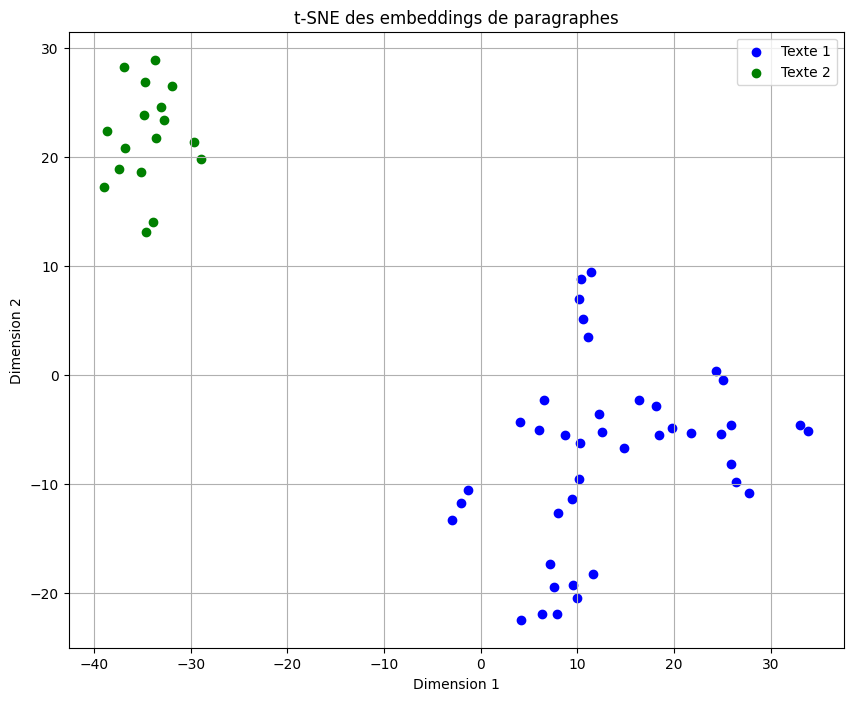

In [69]:
# Réduire les dimensions avec t-SNE (de 768 à 2)
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2D = tsne.fit_transform(embeddings)


couleurs = ['blue', 'green']  # Bleu pour le fichier 1, vert pour le fichier 2
plt.figure(figsize=(10, 8))
for i in range(len(embeddings_2D)):
    # On affiche un point coloré pour chaque paragraphe
    plt.scatter(
        embeddings_2D[i, 0], embeddings_2D[i, 1],
        color=couleurs[etiquettes[i]],
        label=f'Texte {etiquettes[i]+1}' if i == etiquettes.index(etiquettes[i]) else ""
    )

# Ajouter la légende, le titre, les axes et une grille
plt.legend()
plt.title('t-SNE des embeddings de paragraphes')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

On observe que les embeddings de paragraphes sont plus proches des autres embeddings du même texte que des embeddings de l'autre texte !

Supposons maintenant qu'un utilisateur écrive un prompt. Nous pouvons comparer l'embedding du prompt à tous les embeddings de paragraphes afin de trouver les paragraphes les plus similaires. Une mesure de similarité classique pour cela est d'utiliser la similarité cosinus (correspondant au cosinus de l'angle formé entre les 2 descripteurs).

In [70]:
from sklearn.metrics.pairwise import cosine_similarity

# Fonction pour rechercher les paragraphes les plus similaires à une phrase
def trouver_paragraphes_similaires(phrase, model, paragraphes, paragraph_embeddings, top_k=3):
    # Générer l'embedding de la phrase
    embedding_phrase = model.encode([phrase])

    # Calculer la similarité cosinus avec tous les paragraphes
    similarites = cosine_similarity(embedding_phrase, paragraph_embeddings)[0]

    # Récupérer les indices des top_k paragraphes les plus similaires
    indices_top = np.argsort(similarites)[-top_k:][::-1]  # Tri décroissant

    # Afficher les résultats
    print(f"\nPhrase de requête : \"{phrase}\"\n")
    print("Paragraphes les plus similaires :\n")
    for i, idx in enumerate(indices_top):
        print(f"--- Résultat {i+1} (similarité : {similarites[idx]:.4f}) ---")
        print(paragraphes[idx])
        print()

# Exemple d'utilisation
phrase_recherche = "How can we monitor species population in real time."
trouver_paragraphes_similaires(
    phrase=phrase_recherche,
    model=modele,
    paragraphes=tous_les_paragraphes,
    paragraph_embeddings=embeddings,
    top_k=3
)


Phrase de requête : "How can we monitor species population in real time."

Paragraphes les plus similaires :

--- Résultat 1 (similarité : 0.5289) ---
Although it is the most accurate methodology, counting every individual in a population can be difficult, if not impossible.  In most cases ecologists can only attempt to estimate the population size (N) by using well-designed field studies and statistics. Indeed, some population ecologists specialize in developing mathematical and statistical models to accurately estimate population size, such as mark-recapture models and camera-trapping methods (detailed below).  Often, however, we do not have good estimates of the size of a population itself, but factors that should be correlated with the population size, such as the number of animals harvested by hunters or trapped by ecologists or the density of dung found during a survey.

--- Résultat 2 (similarité : 0.5227) ---
Species that are economically important or are central players in ec

In [72]:
phrase_recherche = "Is it possible to learn how to better control our emotions?"
trouver_paragraphes_similaires(
    phrase=phrase_recherche,
    model=modele,
    paragraphes=tous_les_paragraphes,
    paragraph_embeddings=embeddings,
    top_k=3
)


Phrase de requête : "Is it possible to learn how to better control our emotions?"

Paragraphes les plus similaires :

--- Résultat 1 (similarité : 0.3413) ---
Personal improvement
Many people apply behavioral psychology principles to their personal or professional lives. Many self-help books, articles and websites suggest using conditioning methods to help motivate yourself. Increased productivity, building better habits or reducing procrastination are a few examples of potential target behaviors.

--- Résultat 2 (similarité : 0.3167) ---
Behavioral psychology techniques
Here are some behavioral psychology methods therapists, counselors and teachers may use:
Exposure and response prevention: This involves exposing an individual to a stimulus and working to prevent bad coping mechanisms.
Systematic desensitization: This involves exposing a person to a stimulus gradually while using relaxation techniques to reduce their fear of the stimulus.
Token economy: This helps shape behavior by r

On voit bien que les paragraphes les plus similaires au prompt traitent à peu près du même sujet et permettent de donner des éléments de réponse à la question posée. En combinant ce mécanisme à celui de la section précédente, on peut ainsi mettre en place le RAG.

# Partie libre : à vous de jouer

Vous avez maintenant tous les éléments pour mettre en place vous-même un pipeline de RAG.

**Travail à faire**
-   trouver un sujet pour lequel le modèle Dolly répond mal aux questions qu'on lui pose
-   trouver un document à indexer qui traite de ce sujet (par exemple, une ou plusieurs pages Wikipedia, des cours, etc.) et utiliser all-mpnet-base-v2 pour indexer les informations de ce document
-   Intégrer dans un prompt les questions et les informations automatiquement récupérées pour voir si le modèle parvient à répondre plus efficacement aux questions que vous avez identifiées.


Phrase de requête : "When will Nintendo release the Switch 2?"

Paragraphes les plus similaires :

--- Résultat 1 (similarité : 0.8711) ---
Nintendo revealed the Switch 2 on January 16, 2025, followed by its full specifications and release date on April 2. It is scheduled for release in most territories on  June 5, 2025.

--- Résultat 2 (similarité : 0.8208) ---
In 2025, Nintendo announced that the successor to the Switch, the Nintendo Switch 2, would be released on June 5 of that year.

--- Résultat 3 (similarité : 0.7334) ---
On January 16, 2025, the Nintendo Switch 2 was revealed via Nintendo's official channels, introducing its new design and magnetic Joy-Con controllers, as well as a brief footage of a new Mario Kart game, which was later announced as Mario Kart World (2025). A one-hour Nintendo Direct presentation centered around the console premiered on April 2, 2025, with Nintendo Treehouse presentations on Switch 2 games airing in the following 2 days. Nintendo is currently h

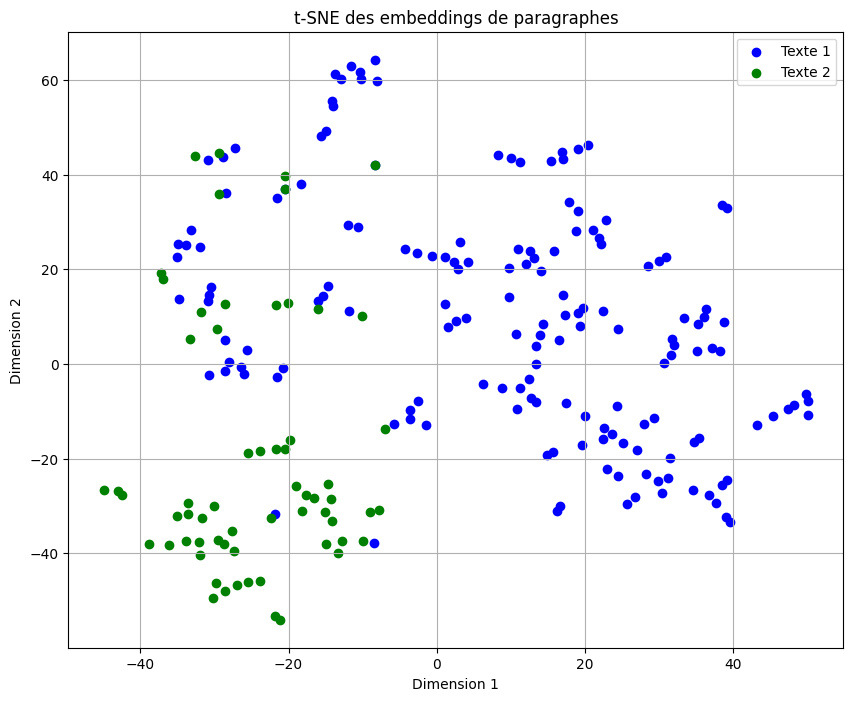

In [87]:
# Charger les paragraphes des deux fichiers
paragraphes_fichier1 = charger_paragraphes('Nintendo.txt')
paragraphes_fichier2 = charger_paragraphes('Nintendo_Switch_2.txt')

# Combiner tous les paragraphes dans une seule liste
tous_les_paragraphes = paragraphes_fichier1 + paragraphes_fichier2

# Créer une liste d’étiquettes : 0 pour le fichier 1, 1 pour le fichier 2
etiquettes = [0] * len(paragraphes_fichier1) + [1] * len(paragraphes_fichier2)

# Modèle
modele = SentenceTransformer('all-mpnet-base-v2')
embeddings = modele.encode(tous_les_paragraphes)

# Réduire les dimensions avec t-SNE (de 768 à 2)
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2D = tsne.fit_transform(embeddings)


couleurs = ['blue', 'green']  # Bleu pour le fichier 1, vert pour le fichier 2
plt.figure(figsize=(10, 8))
for i in range(len(embeddings_2D)):
    # On affiche un point coloré pour chaque paragraphe
    plt.scatter(
        embeddings_2D[i, 0], embeddings_2D[i, 1],
        color=couleurs[etiquettes[i]],
        label=f'Texte {etiquettes[i]+1}' if i == etiquettes.index(etiquettes[i]) else ""
    )

# Ajouter la légende, le titre, les axes et une grille
plt.legend()
plt.title('t-SNE des embeddings de paragraphes')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
#plt.show()

phrase_recherche = "When will Nintendo release the Switch 2?"
trouver_paragraphes_similaires(
    phrase=phrase_recherche,
    model=modele,
    paragraphes=tous_les_paragraphes,
    paragraph_embeddings=embeddings,
    top_k=3
)

context =

prompt = """### Instruction:
""" + phrase_recherche + """

### Context:
""" + context +
"""

### Response:
"""

res = generate_text(prompt)
print(res[0]["generated_text"])